# Titanic ML Workflow 

Import Libraries


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

 Load Dataset


In [20]:
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv"
titanic = pd.read_csv(url)
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Clean and Prepare Data


In [21]:
# Drop irrelevant columns
titanic.drop(columns=['deck', 'embark_town', 'alive', 'class', 'who', 'adult_male', 'alone'], inplace=True)
# Fill missing values
titanic['age'] = titanic['age'].fillna(titanic['age'].median())
titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode()[0])
# Encode categorical variables
titanic['sex'] = titanic['sex'].map({'male': 1, 'female': 0})
titanic = pd.get_dummies(titanic, columns=['embarked'], drop_first=True)
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked_Q,embarked_S
0,0,3,1,22.0,1,0,7.2500,False,True
1,1,1,0,38.0,1,0,71.2833,False,False
2,1,3,0,26.0,0,0,7.9250,False,True
3,1,1,0,35.0,1,0,53.1000,False,True
4,0,3,1,35.0,0,0,8.0500,False,True


Split Features and Labels

In [22]:
X = titanic.drop('survived', axis=1)
y = titanic['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scale Numerical Features

In [23]:
scaler = StandardScaler()
num_cols = ['pclass', 'age', 'sibsp', 'parch', 'fare']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

Train Logistic Regression Model

In [24]:
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

LogisticRegression(max_iter=200)

Make Predictions on Test Data

In [25]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

Evaluate Model Performance

Accuracy: 0.8100558659217877
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Confusion Matrix:
[[90 15]
 [19 55]]
ROC-AUC Score: 0.8826254826254826


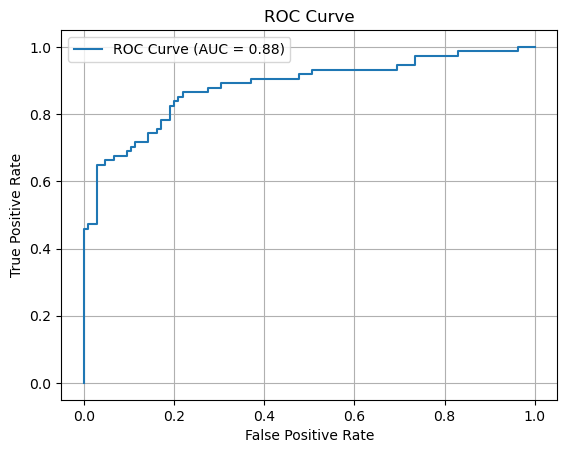

In [26]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n" + classification_report(y_test, y_pred))
print("Confusion Matrix:\n" + str(confusion_matrix(y_test, y_pred)))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

Tune Model with GridSearchCV

In [27]:
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=200), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best hyperparameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Best hyperparameters: {'C': 0.1}
Best CV Accuracy: 0.7962868117797696


Predict Survival for a New Passenger

In [28]:
new_passenger = {
    'pclass': [3], 'sex': [0], 'age': [30.0], 'sibsp': [0],
    'parch': [0], 'fare': [7.25], 'embarked_Q': [0], 'embarked_S': [1]
}
new_X = pd.DataFrame(new_passenger)
new_X[num_cols] = scaler.transform(new_X[num_cols])
prediction = model.predict(new_X)
prediction_prob = model.predict_proba(new_X)[0][1]
print("Predicted class:", prediction[0], "| Probability of survival:", prediction_prob)

Predicted class: 1 | Probability of survival: 0.6034436398626495


Visualize Survival Count by Passenger Class

Text(0, 0.5, 'Count')

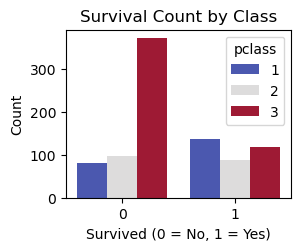

In [ ]:
plt.subplot(2, 2, 1)
sns.countplot(x='survived', hue='pclass', data=titanic, palette='coolwarm')
plt.title("Survival Count by Class")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Count")


Visualize Age Distribution of Survivors vs. Non-Survivors

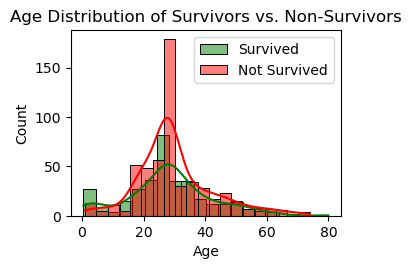

In [ ]:
plt.subplot(2, 2, 2)
sns.histplot(titanic[titanic['survived'] == 1]['age'], bins=20, kde=True, color='green', label='Survived')
sns.histplot(titanic[titanic['survived'] == 0]['age'], bins=20, kde=True, color='red', label='Not Survived')
plt.title("Age Distribution of Survivors vs. Non-Survivors")
plt.xlabel("Age")
plt.legend()
plt.tight_layout()
plt.show()

Visualize Survival Rate by Sex

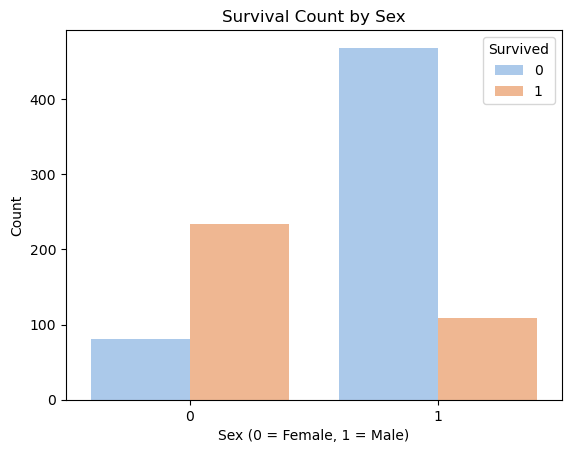

In [32]:
sns.countplot(x='sex', hue='survived', data=titanic, palette='pastel')
plt.title("Survival Count by Sex")
plt.xlabel("Sex (0 = Female, 1 = Male)")
plt.ylabel("Count")
plt.legend(title="Survived")
plt.show()


Visualize Family Size vs. Survival

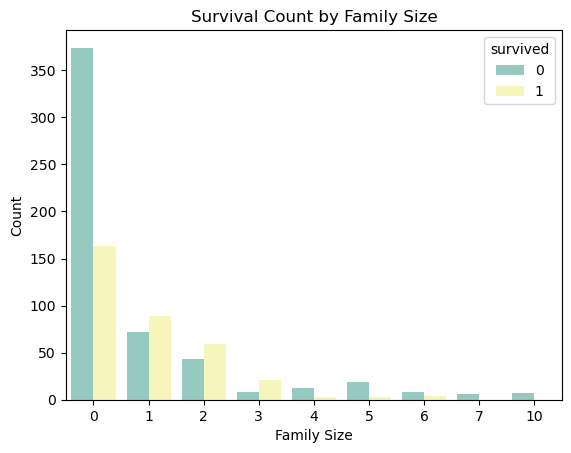

In [35]:
titanic['family_size'] = titanic['sibsp'] + titanic['parch']
sns.countplot(x='family_size', hue='survived', data=titanic, palette='Set3')
plt.title("Survival Count by Family Size")
plt.xlabel("Family Size")
plt.ylabel("Count")
plt.show()
